In [1]:
import numpy as np
import itertools
from scipy.special import expit
import scipy.optimize as optimize

class NeuralNetwork:
    def __init__(self,
                 X: np.ndarray,y: np.ndarray,
                 lam: float = 0.0,
                 hidden_layers: list = [25],
                 nclass: int = 10):
        if X.ndim == 1: 
            X = X[:,None]
        # number of training examples x size of input layer
        self.m,self.n = X.shape
        # training exampls and their classifications  
        self.X,self.y = X,y
        # regularization parameter
        self.lam = lam
        # list of hidden layers with # of activation nodes
        self.hid = hidden_layers
        # number of output classes
        self.nclass = nclass
        # set up shapes of training parameters
        self.shapes = self.init_shapes(self.n,nclass,hidden_layers)
        # set up list of training parameters corresponding to shape in self.shapes
        self.thetas = [self.init_weights(*s) 
                        for s in self.shapes]
        # recalculate shapes with bias
        self.shapes_bias = [th.shape for th in self.thetas] 
    def __call__(self,
                 *args,
                 theta: np.ndarray = None,
                 **kwargs) -> tuple:
        f = lambda t: self.J(self.X,t)
        df = lambda t: self.dJdTheta(self.X,t)
        J = []
        def callback(t):
            J.append(f(t))
        if theta is not None:
            theta = np.array(theta,copy=True)
        else:
            theta = self.ravel(self.thetas)
        sol = optimize.minimize(f,theta,jac=df,**kwargs,callback=callback)
        thetas = self.unravel(sol.x,self.shapes_bias)
        pred = self.predict(self.X,thetas)
        accuracy = np.mean((pred==self.y).astype(float))*100
        print("Back propagation error using 20 random parameters is %.2e"
              %self.gradient_check(ncheck=20,shuffle=True))
        print("Accuracy of training paramters is %.0f"%accuracy,"%")
        return thetas,np.array(J)
    def init_weights(self,
                     cols: int,
                     rows: int,
                     eps: float = 0.12) -> np.ndarray:
        # +1 column for bias units
        return np.random.rand(rows,1+cols)*2*eps - eps
    def init_shapes(self,
                    in_put: int,
                    out_put: int,
                    hid: list) -> list:
        shapes = [(in_put,hid[0])]
        for i in range(1,len(hid)):
            shapes.append((hid[i-1],hid[i]))    
        shapes.append((hid[-1],out_put))
        return shapes
    def sigmoid(self,z: np.ndarray) -> np.ndarray:
        #return 1./(1. + np.exp(-z))
        return expit(z)
    def ravel(self,matrix: list) -> np.ndarray:
        # convenience function to ravel list of training parameters
        return np.hstack([m.ravel() for m in matrix]) 
    def unravel(self,array: np.ndarray,
                shapes: list) -> list:
        # convenience function to unravel list of training parameters
        matrix = []
        lprev = 0
        for s in shapes:
            l = lprev + np.prod(s)
            matrix.append(np.array(array)[lprev:l].reshape(s))
            lprev = l    
        return matrix
    def forward_prop(self,X: np.ndarray,
                     thetas: list) -> tuple:
        m,n = X.shape
        a = X
        # iterate through hidden layers.
        # a represents the activation nodes in each layer
        # thetas is a list of theta params that link the activation nodes
        activations = []
        for th in thetas:
            a = np.column_stack((np.ones(m),a))
            activations.append(a)
            z = np.dot(th,a.T)
            a = self.sigmoid(z).T
        h = a
        activations.append(h)
        # map y values to binary array with same shape as last activaton layer before output
        # classifier at position (i,y[i]) is 1 where y[i] represents the class
        ynew = np.zeros(h.shape)
        for i in range(m):
            ynew[i,self.y[i]] = 1
        J = np.sum(np.sum(1/m*(-ynew*np.log(h + 1e-100) - (1 - ynew)*np.log(1 - h + 1e-100))))
        for th in thetas:
            J += self.lam/(2*m)*np.sum(np.sum(th[:,1:]**2))
        return J,activations,ynew
    def backward_prop(self,X: np.ndarray,
                      thetas: list) -> list:
        m,n = X.shape
        # run forward propagation to acquire the activation nodes in each layer
        J,activations,ynew = self.forward_prop(X,thetas)
        # start of back propagation
        h = activations[-1]
        _delta = h - ynew
        delta = [_delta]
        # compute error of each layer
        # skip bias terms in the hidden layers
        for i in range(len(activations)-2,0,-1):
            if i < len(activations)-2 and i > 0:
                _delta = np.dot(_delta[:,1:],thetas[i])*activations[i]*(1 - activations[i])
            else:
                _delta = np.dot(_delta,thetas[i])*activations[i]*(1 - activations[i])
            delta.append(_delta)
        delta.reverse()
        # compute unregularized gradients 
        # skip bias terms in hidden layers
        Delta = []
        for i in range(len(activations)-1):
            #print(i,delta[i].shape,activations[i].shape)
            d,a = delta[i],activations[i]
            #if i == 0:
            if i == 0 or i < len(activations)-2 :
                d = d[:,1:]
            Delta.append(1/m*np.dot(d.T,a))
        for i in range(len(Delta)):
            Delta[i][:,1:] += self.lam/m*thetas[i][:,1:] 
        """
        for (i,d) in enumerate(delta):
            print("delta_%g = "%(i+2),d.shape)
        for (i,a) in enumerate(activations):
            print("a_%g = "%(i+1),a.shape)
        for (i,t) in enumerate(thetas):
            print("theta_%g = "%(i+1),t.shape)
        for (i,d) in enumerate(Delta):
            print("Delta_%g = "%(i+1),d.shape)
        """
        return Delta
    def gradient_check(self,ncheck: int = 100,
                       eps: float = 1e-4,
                       shuffle: bool = True) -> float:
        thetas = self.thetas
        Delta = self.backward_prop(self.X,thetas)
        Delta = self.ravel(Delta)
        # estimate derivative
        shapes = self.shapes_bias
        thetas = self.ravel(thetas)
        if shuffle:
            pos = np.random.permutation(len(Delta))[:ncheck]
        else:
            pos = [i for i in range(len(Delta))][:ncheck]
        grad = []
        dtheta = eps
        f = lambda t: self.forward_prop(self.X,self.unravel(t,shapes))[0]
        dJ = []
        eps = np.zeros(thetas.shape)
        for i in pos:
            eps[i] = dtheta
            up = thetas + eps
            down = thetas - eps
            dJ.append((f(up) - f(down))/(2*dtheta))
            eps[i] = 0
        dJ = np.array(dJ)
        # error of numerical derivative estimation
        err = np.linalg.norm(dJ-Delta[pos])/np.linalg.norm(dJ+Delta[pos])
        return err
    def J(self,X: np.ndarray,
          thetas: np.ndarray) -> float:
        # input is 1d array of thetas that has been flattend. unravel it
        thetas = self.unravel(thetas,self.shapes_bias)
        # run forward propagation
        J,_,_ = self.forward_prop(X,thetas)
        return J
    def dJdTheta(self,X: np.ndarray,
                 thetas: np.ndarray) -> np.ndarray:
        # input is 1d array of thetas that has been flattend. unravel it
        thetas = self.unravel(thetas,self.shapes_bias)
        # run backward propagation
        dJ = self.backward_prop(X,thetas)
        return self.ravel(dJ)
    def predict(self,X: np.ndarray,
                thetas: list) -> np.ndarray:
        _,a,_ = self.forward_prop(X,thetas)
        return np.argmax(a[-1],axis=-1)
    def costfunction(self,X: np.ndarray,
                     thetas: list) -> tuple:
        # run foward and backward propagation
        J,dJ = self.J(X,thetas),self.dJdTheta(X,thetas)
        return J,dJ
    def GradientDescent(self,
                        alpha=1.0,
                        steps=1000,
                        adagrad=False,
                        theta=None):
        # gradient descent modified with adagrad learning rate.
        # set adagrad = False to turn off 
        if theta is not None:
            theta = np.array(theta,copy=True)
        else:
            theta = self.ravel(self.thetas)
        s = 0
        Jprev = 0
        sol = []
        for i in range(steps):
            J,dJ = self.costfunction(self.X,theta)
            if adagrad:
                s += dJ@dJ
                theta = theta - alpha/np.sqrt(s + 1e-8)*dJ
                Jprev = J
            else:
                theta = theta - alpha*dJ
            sol.append(J)
        thetas = self.unravel(theta,self.shapes_bias)
        pred = self.predict(self.X,thetas)
        accuracy = np.mean((pred==self.y).astype(float))*100
        print("Back propagation error using 20 random parameters is %.2e"
              %self.gradient_check(ncheck=20,shuffle=True))
        print("Accuracy of training paramters is %.0f"%accuracy,"%")
        return thetas,np.array(sol)
    def display_data(self,shape=(),X=None,nrows=10,ncols=10,shuffle=True,**kwargs):
        if X is None:
            X = self.X
        if shuffle:
            X = np.random.permutation(X)
        fig, ax = plt.subplots(nrows,ncols)
        for i, ax in enumerate(ax.flatten()):
            image = X[i,:].reshape(shape)
            ax.imshow(image.T,**kwargs)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.axis('off')
        return fig,ax

Back propagation error using 20 random parameters is 6.19e-10
Accuracy of training paramters is 96 %


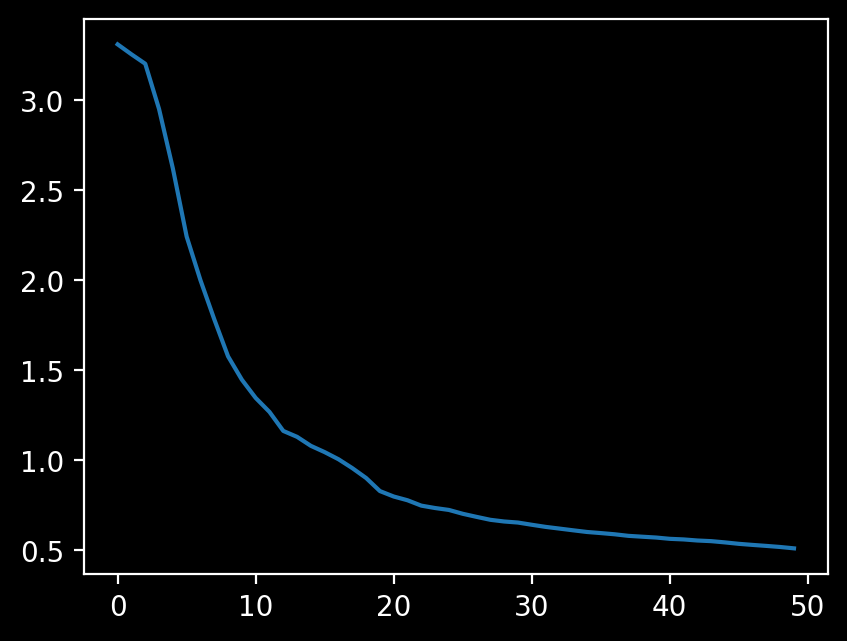

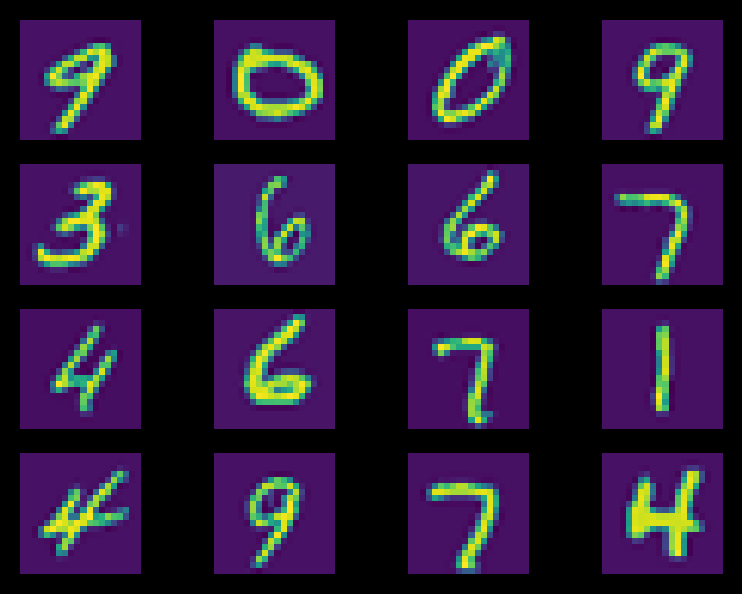

[[9 0 0 9]
 [3 6 6 7]
 [4 6 7 1]
 [4 9 7 4]]


In [2]:
if (__name__ == "__main__") :
    import matplotlib.pyplot as plt
    import pickle
    
    with open('ex4data1.pkl', 'rb') as f:   
        data = pickle.load(f)
    # data consists of 
    data = np.array(data,dtype=float)
    X = data[:,:-1]
    y = data[:,-1].astype(int)
    l = np.where(y == 10)
    y[l] = 0
    
    NN = NeuralNetwork(X,y,
                   lam=1,
                   hidden_layers=[25],
                   nclass=10)
    #thetas,J = NN.GradientDescent(1,steps=100)
    thetas,J = NN(method="CG",
                  options={'maxiter':50})
    plt.plot(J)
    plt.show()
    pos = np.random.permutation(len(X))[:16]
    x = X[pos,:]
    NN.display_data(X=x,shape=(20,20),nrows=4,ncols=4,shuffle=False)
    plt.show()
    print(NN.predict(x,thetas).reshape(4,4))